# MARBERT Advanced Training for Arabic Polarization Detection - Google Colab

This notebook trains and evaluates MARBERT and MARBERT v2 models on the **advanced preprocessed** Arabic dataset (with morphological segmentation).

**Dataset**: Advanced preprocessed Arabic text with morphological segmentation
**Models**:
- MARBERT (UBC-NLP/MARBERT)
- MARBERT v2 (UBC-NLP/MARBERTv2)

**Task**: Binary classification (polarization detection)

**Steps**:
1. Install dependencies
2. Upload preprocessed dataset
3. Train MARBERT and MARBERT v2
4. Compare results
5. Download trained models

## 1. Setup: Install Required Packages

In [1]:
!pip install transformers torch scikit-learn pandas numpy tqdm accelerate matplotlib seaborn -q
print("✓ Packages installed successfully")

✓ Packages installed successfully


## 2. Import Libraries

In [2]:
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding
)
from datasets import Dataset
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
from google.colab import files
import warnings
warnings.filterwarnings('ignore')

# Check GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")
else:
    print("⚠️ Warning: GPU not available. Training will be slow on CPU.")

Using device: cuda
GPU: Tesla T4
Memory: 14.74 GB


## 3. Upload Preprocessed Dataset

Upload your `arb_clean_advanced.csv` file (the output from advanced preprocessing).

In [3]:
print("Please upload your arb_clean_advanced.csv file:")
print("You should see a 'Choose Files' button below.\n")

uploaded = files.upload()

if 'arb_clean_advanced.csv' in uploaded:
    print("\n✓ Dataset uploaded successfully!")
    print(f"  File size: {len(uploaded['arb_clean_advanced.csv']) / 1024:.2f} KB")
else:
    print("\n⚠️ Warning: arb_clean_advanced.csv not found")
    print(f"Files received: {list(uploaded.keys())}")

Please upload your arb_clean_advanced.csv file:
You should see a 'Choose Files' button below.



Saving arb_clean_advanced.csv to arb_clean_advanced.csv

✓ Dataset uploaded successfully!
  File size: 710.55 KB


## 4. Load and Explore Dataset

In [4]:
# Load the advanced preprocessed dataset
data_path = 'arb_clean_advanced.csv'
df = pd.read_csv(data_path)

print(f"✓ Dataset loaded successfully!")
print(f"  Shape: {df.shape}")
print(f"  Columns: {list(df.columns)}")
print(f"\nFirst few rows:")
print(df.head())
print(f"\nClass distribution:")
print(df['polarization'].value_counts())
print(f"\nClass balance:")
print(df['polarization'].value_counts(normalize=True))

# Show some sample preprocessed texts
print(f"\n{'='*80}")
print("Sample advanced preprocessed texts:")
print(f"{'='*80}")
for i in range(3):
    print(f"\nText {i+1}: {df['text'].iloc[i][:100]}...")
    print(f"Label: {df['polarization'].iloc[i]}")

✓ Dataset loaded successfully!
  Shape: (3380, 3)
  Columns: ['id', 'text', 'polarization']

First few rows:
                                     id  \
0  arb_a2a60c8b4af3389e842d8ec31afb0eea   
1  arb_6723e56a672674a6c1d9b28b213c4a05   
2  arb_b0365d606edeee38ae6c025b1ca33e96   
3  arb_858c0ee684049ba6f416a6cecb0b0761   
4  arb_bdafc73afd0bc2cd2badae2a089446b9   

                                                text  polarization  
0  أحلام أنتي و+ نعالي ومنو أنتي حتى تقيمين الفنا...             1  
1  وره الكواليس تنيجج من وره بعير صطناعي على ف+ ك...             1  
2  .خخخخ الملكة أحلام فيها شذوذ شنو هل بوس و+ الد...             1  
3  الله يخزى أحلام هي و+ البرنامج الخايس إلى كله ...             1  
4  كس أم أحلام إلى ماربتها وش ملكه هههه متستاهل م...             1  

Class distribution:
polarization
0    1868
1    1512
Name: count, dtype: int64

Class balance:
polarization
0    0.552663
1    0.447337
Name: proportion, dtype: float64

Sample advanced preprocessed texts:

Text 1: أح

## 5. Split Data (90/10 Train/Test with Stratification)

In [5]:
# Split with stratification to maintain class balance
RANDOM_STATE = 42

train_df, test_df = train_test_split(
    df,
    test_size=0.1,
    random_state=RANDOM_STATE,
    stratify=df['polarization']
)

print(f"Train set size: {len(train_df)} ({len(train_df)/len(df)*100:.1f}%)")
print(f"Test set size: {len(test_df)} ({len(test_df)/len(df)*100:.1f}%)")

print(f"\nTrain set class distribution:")
print(train_df['polarization'].value_counts())
print(f"\nTest set class distribution:")
print(test_df['polarization'].value_counts())

print(f"\nClass balance verification:")
print(f"Train: {train_df['polarization'].value_counts(normalize=True).to_dict()}")
print(f"Test:  {test_df['polarization'].value_counts(normalize=True).to_dict()}")

Train set size: 3042 (90.0%)
Test set size: 338 (10.0%)

Train set class distribution:
polarization
0    1681
1    1361
Name: count, dtype: int64

Test set class distribution:
polarization
0    187
1    151
Name: count, dtype: int64

Class balance verification:
Train: {0: 0.5525969756738988, 1: 0.44740302432610124}
Test:  {0: 0.5532544378698225, 1: 0.4467455621301775}


## 6. Prepare Datasets for Training

In [6]:
# Convert to HuggingFace Dataset format
train_dataset = Dataset.from_pandas(train_df[['text', 'polarization']].rename(columns={'polarization': 'label'}))
test_dataset = Dataset.from_pandas(test_df[['text', 'polarization']].rename(columns={'polarization': 'label'}))

print(f"✓ Datasets prepared")
print(f"Train dataset: {train_dataset}")
print(f"Test dataset: {test_dataset}")

✓ Datasets prepared
Train dataset: Dataset({
    features: ['text', 'label', '__index_level_0__'],
    num_rows: 3042
})
Test dataset: Dataset({
    features: ['text', 'label', '__index_level_0__'],
    num_rows: 338
})


## 7. Helper Functions for Training and Evaluation

In [7]:
def tokenize_function(examples, tokenizer):
    """Tokenize the texts"""
    return tokenizer(examples['text'], truncation=True, padding=False, max_length=512)

def compute_metrics(eval_pred):
    """Compute metrics for evaluation"""
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)

    accuracy = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average='weighted')

    return {
        'accuracy': accuracy,
        'f1': f1
    }

def plot_confusion_matrix(y_true, y_pred, title="Confusion Matrix"):
    """Plot confusion matrix"""
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

def evaluate_model(trainer, test_dataset, model_name):
    """Evaluate model and print detailed metrics"""
    print(f"\n{'='*80}")
    print(f"Evaluating {model_name}")
    print(f"{'='*80}")

    # Get predictions
    predictions = trainer.predict(test_dataset)
    preds = np.argmax(predictions.predictions, axis=1)
    labels = predictions.label_ids

    # Print metrics
    print("\nClassification Report:")
    print(classification_report(labels, preds, target_names=['Class 0', 'Class 1']))

    # Plot confusion matrix
    plot_confusion_matrix(labels, preds, title=f"{model_name} - Confusion Matrix")

    # Return metrics
    return {
        'accuracy': accuracy_score(labels, preds),
        'f1': f1_score(labels, preds, average='weighted'),
        'predictions': predictions
    }

print("✓ Helper functions defined")

✓ Helper functions defined


## 8. Train MARBERT Model

In [8]:
# Load MARBERT tokenizer and model
marbert_model_name = "UBC-NLP/MARBERT"
print(f"Loading {marbert_model_name}...")

marbert_tokenizer = AutoTokenizer.from_pretrained(marbert_model_name)
marbert_model = AutoModelForSequenceClassification.from_pretrained(
    marbert_model_name,
    num_labels=2
)

# Tokenize datasets
print("Tokenizing datasets...")
marbert_train_dataset = train_dataset.map(
    lambda x: tokenize_function(x, marbert_tokenizer),
    batched=True
)
marbert_test_dataset = test_dataset.map(
    lambda x: tokenize_function(x, marbert_tokenizer),
    batched=True
)

print(f"✓ Model loaded and datasets tokenized")
print(f"  Train dataset size: {len(marbert_train_dataset)}")
print(f"  Test dataset size: {len(marbert_test_dataset)}")

Loading UBC-NLP/MARBERT...


tokenizer_config.json:   0%|          | 0.00/376 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/701 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/654M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/654M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at UBC-NLP/MARBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Tokenizing datasets...


Map:   0%|          | 0/3042 [00:00<?, ? examples/s]

Map:   0%|          | 0/338 [00:00<?, ? examples/s]

✓ Model loaded and datasets tokenized
  Train dataset size: 3042
  Test dataset size: 338


In [9]:
# Set up training arguments
training_args = TrainingArguments(
    output_dir='./results_marbert_advanced',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs_marbert_advanced',
    logging_steps=100,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    seed=RANDOM_STATE
)

# Create data collator for dynamic padding
data_collator = DataCollatorWithPadding(tokenizer=marbert_tokenizer)

# Create Trainer
marbert_trainer = Trainer(
    model=marbert_model,
    args=training_args,
    train_dataset=marbert_train_dataset,
    eval_dataset=marbert_test_dataset,
    compute_metrics=compute_metrics,
    data_collator=data_collator
)

# Train the model
print("Training MARBERT on advanced preprocessed data...")
print("This may take 10-20 minutes depending on dataset size...\n")
marbert_trainer.train()
print("✓ MARBERT training complete!")

Training MARBERT on advanced preprocessed data...
This may take 10-20 minutes depending on dataset size...



wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: nuh-alsharafi (deepclean415445) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.599000,0.414000,0.786982,0.785648
2,0.357700,0.428030,0.828402,0.828793
3,0.229800,0.768822,0.804734,0.805262


✓ MARBERT training complete!


## 9. Evaluate MARBERT Model


Evaluating MARBERT (Advanced Preprocessing)



Classification Report:
              precision    recall  f1-score   support

     Class 0       0.90      0.78      0.83       187
     Class 1       0.76      0.89      0.82       151

    accuracy                           0.83       338
   macro avg       0.83      0.83      0.83       338
weighted avg       0.84      0.83      0.83       338



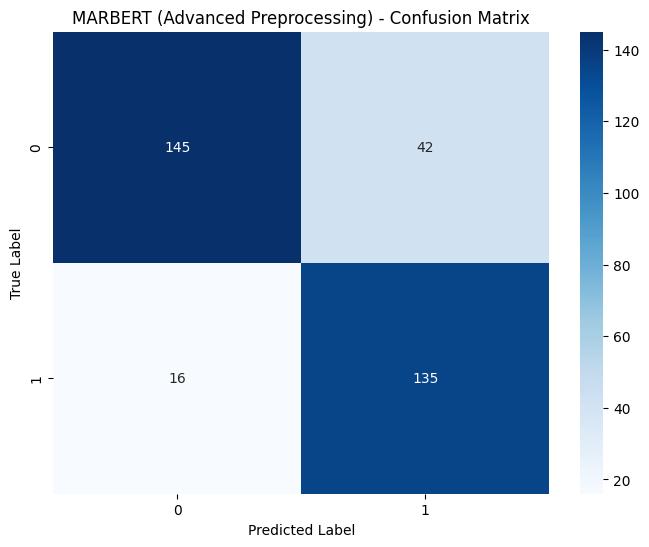


✓ MARBERT Accuracy: 0.8284
✓ MARBERT F1 Score: 0.8288


In [10]:
# Evaluate MARBERT
marbert_results = evaluate_model(marbert_trainer, marbert_test_dataset, "MARBERT (Advanced Preprocessing)")
print(f"\n✓ MARBERT Accuracy: {marbert_results['accuracy']:.4f}")
print(f"✓ MARBERT F1 Score: {marbert_results['f1']:.4f}")

## 10. Train MARBERT v2 Model

In [11]:
# Load MARBERT v2 tokenizer and model
marbertv2_model_name = "UBC-NLP/MARBERTv2"
print(f"Loading {marbertv2_model_name}...")

marbertv2_tokenizer = AutoTokenizer.from_pretrained(marbertv2_model_name)
marbertv2_model = AutoModelForSequenceClassification.from_pretrained(
    marbertv2_model_name,
    num_labels=2
)

# Tokenize datasets
print("Tokenizing datasets...")
marbertv2_train_dataset = train_dataset.map(
    lambda x: tokenize_function(x, marbertv2_tokenizer),
    batched=True
)
marbertv2_test_dataset = test_dataset.map(
    lambda x: tokenize_function(x, marbertv2_tokenizer),
    batched=True
)

print(f"✓ Model loaded and datasets tokenized")
print(f"  Train dataset size: {len(marbertv2_train_dataset)}")
print(f"  Test dataset size: {len(marbertv2_test_dataset)}")

Loading UBC-NLP/MARBERTv2...


tokenizer_config.json:   0%|          | 0.00/439 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/757 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/654M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/654M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at UBC-NLP/MARBERTv2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Tokenizing datasets...


Map:   0%|          | 0/3042 [00:00<?, ? examples/s]

Map:   0%|          | 0/338 [00:00<?, ? examples/s]

✓ Model loaded and datasets tokenized
  Train dataset size: 3042
  Test dataset size: 338


In [12]:
# Set up training arguments for MARBERT v2
training_args_v2 = TrainingArguments(
    output_dir='./results_marbertv2_advanced',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs_marbertv2_advanced',
    logging_steps=100,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    seed=RANDOM_STATE
)

# Create data collator for dynamic padding
data_collator_v2 = DataCollatorWithPadding(tokenizer=marbertv2_tokenizer)

# Create Trainer
marbertv2_trainer = Trainer(
    model=marbertv2_model,
    args=training_args_v2,
    train_dataset=marbertv2_train_dataset,
    eval_dataset=marbertv2_test_dataset,
    compute_metrics=compute_metrics,
    data_collator=data_collator_v2
)

# Train the model
print("Training MARBERT v2 on advanced preprocessed data...")
print("This may take 10-20 minutes depending on dataset size...\n")
marbertv2_trainer.train()
print("✓ MARBERT v2 training complete!")

Training MARBERT v2 on advanced preprocessed data...
This may take 10-20 minutes depending on dataset size...



Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.654900,0.383893,0.828402,0.828890
2,0.347000,0.487361,0.795858,0.793422
3,0.287000,0.623656,0.810651,0.810651


✓ MARBERT v2 training complete!


## 11. Evaluate MARBERT v2 Model


Evaluating MARBERT v2 (Advanced Preprocessing)



Classification Report:
              precision    recall  f1-score   support

     Class 0       0.88      0.80      0.84       187
     Class 1       0.78      0.87      0.82       151

    accuracy                           0.83       338
   macro avg       0.83      0.83      0.83       338
weighted avg       0.83      0.83      0.83       338



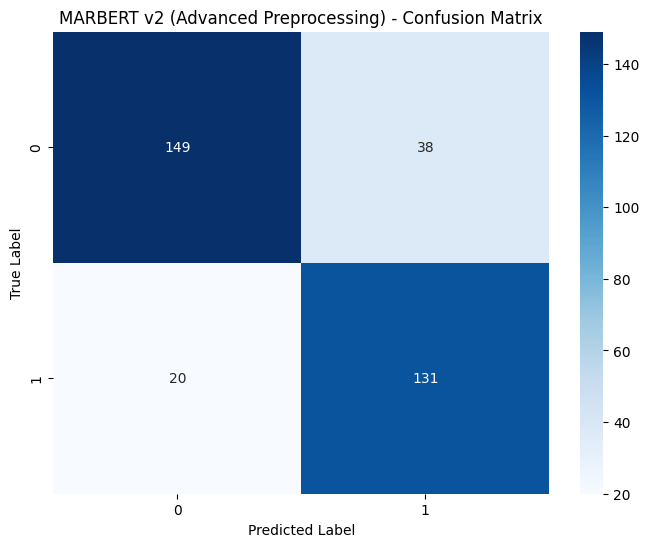


✓ MARBERT v2 Accuracy: 0.8284
✓ MARBERT v2 F1 Score: 0.8289


In [13]:
# Evaluate MARBERT v2
marbertv2_results = evaluate_model(marbertv2_trainer, marbertv2_test_dataset, "MARBERT v2 (Advanced Preprocessing)")
print(f"\n✓ MARBERT v2 Accuracy: {marbertv2_results['accuracy']:.4f}")
print(f"✓ MARBERT v2 F1 Score: {marbertv2_results['f1']:.4f}")

## 12. Compare Results: MARBERT vs MARBERT v2


FINAL RESULTS COMPARISON - Advanced Preprocessing
                Model  Accuracy  F1 Score
   MARBERT (Advanced)  0.828402  0.828793
MARBERT v2 (Advanced)  0.828402  0.828890


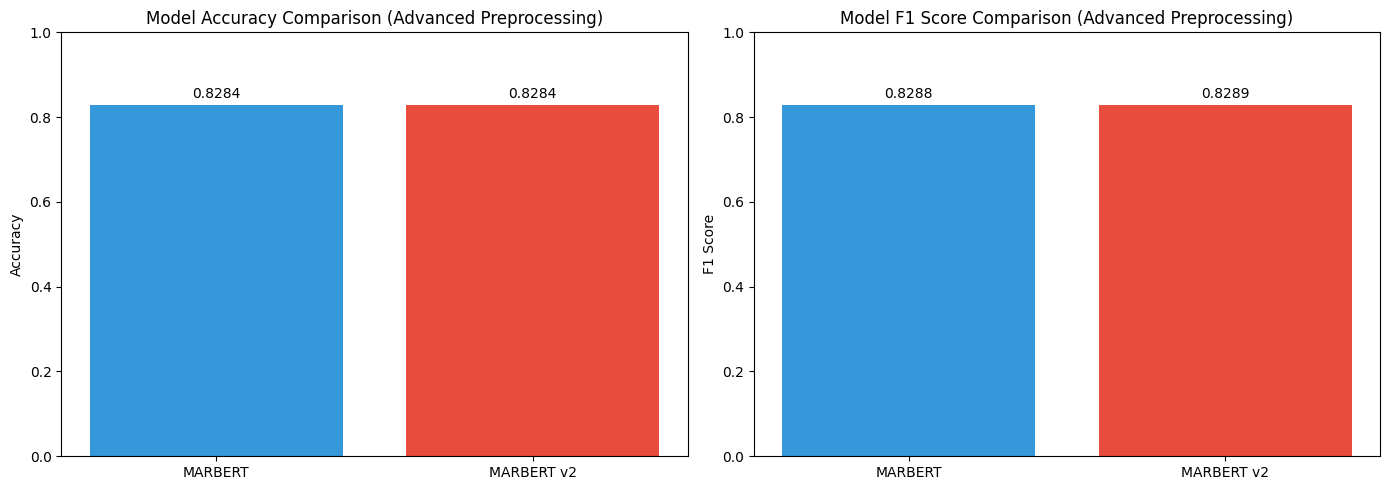


🏆 Winner: MARBERT v2
   Improvement: +0.0001 F1 score

Note: These results are from ADVANCED preprocessing
      (with morphological segmentation)


In [14]:
# Create comparison table
comparison_df = pd.DataFrame({
    'Model': ['MARBERT (Advanced)', 'MARBERT v2 (Advanced)'],
    'Accuracy': [marbert_results['accuracy'], marbertv2_results['accuracy']],
    'F1 Score': [marbert_results['f1'], marbertv2_results['f1']]
})

print("\n" + "="*80)
print("FINAL RESULTS COMPARISON - Advanced Preprocessing")
print("="*80)
print(comparison_df.to_string(index=False))
print("="*80)

# Plot comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy comparison
models = ['MARBERT', 'MARBERT v2']
accuracy_scores = [marbert_results['accuracy'], marbertv2_results['accuracy']]
ax1.bar(models, accuracy_scores, color=['#3498db', '#e74c3c'])
ax1.set_ylabel('Accuracy')
ax1.set_title('Model Accuracy Comparison (Advanced Preprocessing)')
ax1.set_ylim([0, 1])
for i, v in enumerate(accuracy_scores):
    ax1.text(i, v + 0.01, f'{v:.4f}', ha='center', va='bottom')

# F1 Score comparison
f1_scores = [marbert_results['f1'], marbertv2_results['f1']]
ax2.bar(models, f1_scores, color=['#3498db', '#e74c3c'])
ax2.set_ylabel('F1 Score')
ax2.set_title('Model F1 Score Comparison (Advanced Preprocessing)')
ax2.set_ylim([0, 1])
for i, v in enumerate(f1_scores):
    ax2.text(i, v + 0.01, f'{v:.4f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Determine winner
if marbert_results['f1'] > marbertv2_results['f1']:
    winner = "MARBERT"
    improvement = marbert_results['f1'] - marbertv2_results['f1']
elif marbertv2_results['f1'] > marbert_results['f1']:
    winner = "MARBERT v2"
    improvement = marbertv2_results['f1'] - marbert_results['f1']
else:
    winner = "TIE"
    improvement = 0

print(f"\n🏆 Winner: {winner}")
if winner != "TIE":
    print(f"   Improvement: +{improvement:.4f} F1 score")

print(f"\n{'='*80}")
print("Note: These results are from ADVANCED preprocessing")
print("      (with morphological segmentation)")
print(f"{'='*80}")

## 13. Save and Download Models (Optional)

In [ ]:
# Save models
print("Saving models...\n")

marbert_trainer.save_model('./marbert_advanced_final')
print("✓ MARBERT saved to: ./marbert_advanced_final")

marbertv2_trainer.save_model('./marbertv2_advanced_final')
print("✓ MARBERT v2 saved to: ./marbertv2_advanced_final")

print("\nModels saved successfully!")

In [ ]:
# Create results summary file
results_summary = f"""
MARBERT Advanced Training Results
==================================

Dataset: Advanced Preprocessed Arabic (Morphological Segmentation)
Train Size: {len(train_df)}
Test Size: {len(test_df)}

MARBERT Results:
  Accuracy: {marbert_results['accuracy']:.4f}
  F1 Score: {marbert_results['f1']:.4f}

MARBERT v2 Results:
  Accuracy: {marbertv2_results['accuracy']:.4f}
  F1 Score: {marbertv2_results['f1']:.4f}

Winner: {winner}
"""

with open('results_advanced_summary.txt', 'w', encoding='utf-8') as f:
    f.write(results_summary)

print("Downloading results summary...")
files.download('results_advanced_summary.txt')
print("✓ Results summary downloaded!")

## Optional: Download Model Checkpoints

If you want to download the trained models, compress and download them:

In [ ]:
# Compress and download models (uncomment to use)
# Warning: Model files are large (~500MB+ each)

# !zip -r marbert_advanced_final.zip ./marbert_advanced_final
# !zip -r marbertv2_advanced_final.zip ./marbertv2_advanced_final

# print("Downloading MARBERT model...")
# files.download('marbert_advanced_final.zip')

# print("Downloading MARBERT v2 model...")
# files.download('marbertv2_advanced_final.zip')

# print("✓ Models downloaded!")